# AE (AutoEncoder)

## 1. Load dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive/')  # mount your Google Drive to access datasets stored in your drive

Mounted at /content/drive/


In [2]:
!mkdir /content/drive/MyDrive/Colab\ Notebooks/data_2000  # create a folder for the uploaded data; you can change the file path if needed
!unzip -o /content/drive/MyDrive/Colab\ Notebooks/data_2000.zip -d /content/drive/MyDrive/Colab\ Notebooks/data_2000

Archive:  /content/drive/MyDrive/Colab Notebooks/data_2000.zip
 extracting: /content/drive/MyDrive/Colab Notebooks/data_2000/23.119.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_2000/23.149.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_2000/23.2255.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_2000/23.3077.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_2000/23.3701.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_2000/23.388.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_2000/23.4706.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_2000/23.4904.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_2000/23.5079.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_2000/23.5762.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_2000/23.587.jpg  
 extracting: /content/drive/MyDrive/Colab Notebooks/data_2000/23.5886.jpg  
 extracting: /content/drive/M

## 2. Import python libraries

In [3]:
import numpy as np  # library for numerical calculations
import pandas as pd  # data analysis library
import cv2 as cv  # computer vision library for image processing
import matplotlib.pyplot as plt  # visualization library for charts and plots
import os  # operating system library for file handling

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim  # model optimization
from torch.utils.data import DataLoader, TensorDataset  # dataset management
from torchsummary import summary  # model summary

import scipy.io
from sklearn.model_selection import train_test_split  # split data into training and testing sets

print(torch.__version__)      # check pytorch version

2.4.0+cu121


## 3. Convert images into trainable data & Split dataset

In [4]:
# image size = 56 x 56, 2000 images

# specify the below path to the unzipped data (ensure it ends with '/')
# you can change the file path if needed
src = '/content/drive/MyDrive/Colab Notebooks/data_2000/'

# function to read images
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)  # convert the image to grayscale
    return img

files = os.listdir(src)  # get the list of files in the source directory

X,Y = [],[]  # initialize empty lists for storing images and labels

# loop through the files, read each image, and normalize it (0 to 1)
for file in files:
  X.append(img_read(src,file)/255.)
  Y.append(float(file[:-4]))

# split the data into 80% training set and 20% test set (test set can be considered as validation)
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)
x_train = np.array(x_train)
x_test = np.array(x_test)


# reshape the (image,image) images into (image*image,) size vectors
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))).astype('float32')
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))).astype('float32')

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(x_train),np.shape(x_test)))

Datasets_train_shape:(1600, 3136)  Datasets_test_shape:(400, 3136)


## 4. Set model hyperparameters

In [5]:
# model architecture parameters
image_size = np.shape(x_train[0])[0]  # (fixed) input size
mid_dim = 512  # hidden layer(middle) dimension
h_dim = 20  # hidden layer(latent) dimension

# training parameters
num_epochs = 200
batch_size = 20
learning_rate = 1e-3

## 5. Set to model architecture

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(image_size, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, h_dim),
            nn.ReLU())

        self.decoder = nn. Sequential(
            nn.Linear(h_dim, mid_dim),
            nn.ReLU(),
            nn.Linear(mid_dim, image_size),
            nn.ReLU())

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

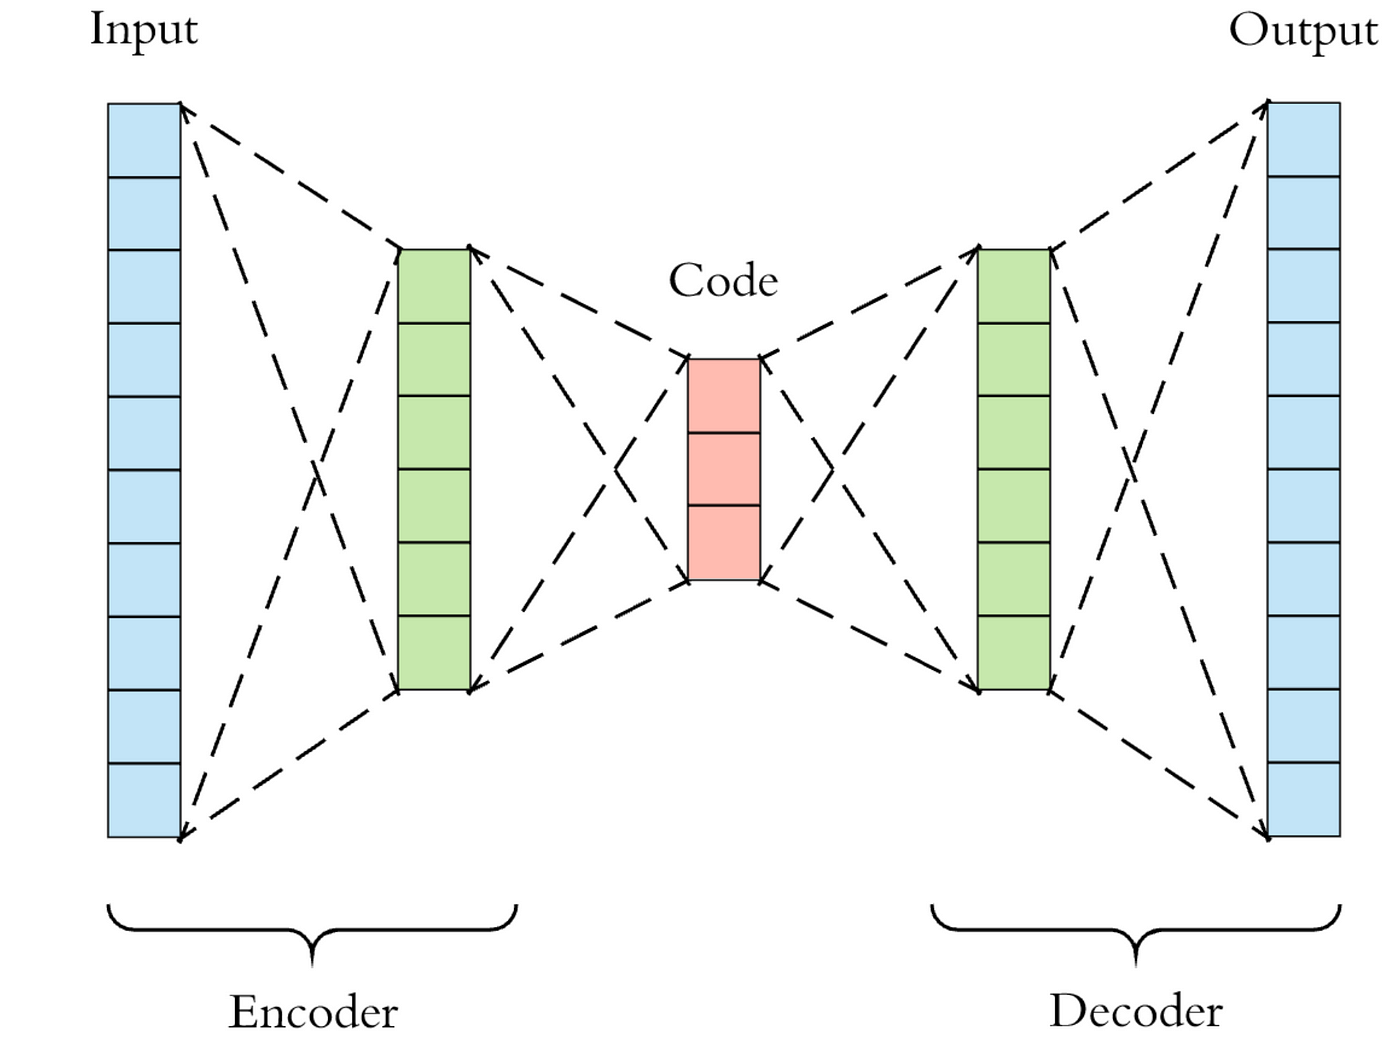

In [7]:
autoencoder = Autoencoder().to('cuda')

# print the model's summary
summary(autoencoder, (image_size,))  # input shape: (channels, height, width)

autoencoder

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,606,144
              ReLU-2                  [-1, 512]               0
            Linear-3                   [-1, 20]          10,260
              ReLU-4                   [-1, 20]               0
            Linear-5                  [-1, 512]          10,752
              ReLU-6                  [-1, 512]               0
            Linear-7                 [-1, 3136]       1,608,768
              ReLU-8                 [-1, 3136]               0
Total params: 3,235,924
Trainable params: 3,235,924
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 12.34
Estimated Total Size (MB): 12.42
----------------------------------------------------------------


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=20, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3136, bias=True)
    (3): ReLU()
  )
)

## 6. Train model

In [8]:
# set to loss function & optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

In [9]:
# convert data to PyTorch tensors
train_images = torch.tensor(x_train, dtype=torch.float32).to('cuda')
train_labels = torch.tensor(y_train, dtype=torch.float32) # don't need to use labels
test_images = torch.tensor(x_test, dtype=torch.float32).to('cuda')
test_labels = torch.tensor(y_test, dtype=torch.float32)   # don't need to use labels

# create DataLoader for training and validation data
train_dataset = TensorDataset(train_images, train_images)  # labels are not needed in autoencoder
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
# train the model
for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0.0

    for x, _ in train_loader:
        optimizer.zero_grad()
        output = autoencoder(x)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss_train = total_loss / len(train_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train_loss: {average_loss_train}")

# Save the model
torch.save(autoencoder.state_dict(), 'AE_model.pth')

Epoch [1/200], Train_loss: 0.15597568871453404
Epoch [2/200], Train_loss: 0.08503297725692391
Epoch [3/200], Train_loss: 0.07395379832014441
Epoch [4/200], Train_loss: 0.06938142604194582
Epoch [5/200], Train_loss: 0.06604728945530951
Epoch [6/200], Train_loss: 0.06234058984555304
Epoch [7/200], Train_loss: 0.059283123398199675
Epoch [8/200], Train_loss: 0.05682345987297595
Epoch [9/200], Train_loss: 0.05499679939821363
Epoch [10/200], Train_loss: 0.052074652584269646
Epoch [11/200], Train_loss: 0.05031966930255294
Epoch [12/200], Train_loss: 0.04864417733624578
Epoch [13/200], Train_loss: 0.04766374416649342
Epoch [14/200], Train_loss: 0.045970715349540114
Epoch [15/200], Train_loss: 0.04512668284587562
Epoch [16/200], Train_loss: 0.04452004018239677
Epoch [17/200], Train_loss: 0.04395135389640927
Epoch [18/200], Train_loss: 0.04329647310078144
Epoch [19/200], Train_loss: 0.04271686165593565
Epoch [20/200], Train_loss: 0.042194497492164376
Epoch [21/200], Train_loss: 0.041118603013455

## 7. Load & Evaluate model

- Compare the orginial image and the reconstructed image

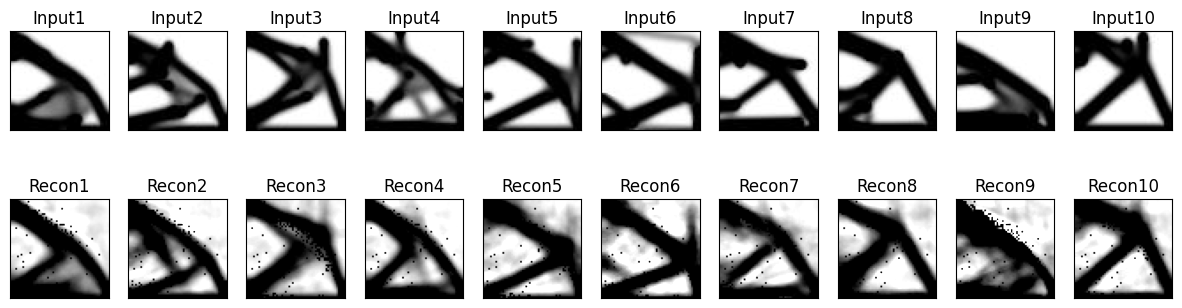

In [11]:
autoencoder.eval().to('cuda')

# proceed reconstruction of the bracket images through the trained autoencoder model
recon_x_test = autoencoder(test_images)

n = 10  # how many images to display

plt.figure(figsize=(15, 4)) # figure size

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images.cpu()[i].reshape(56,56), vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Input"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test.detach().cpu()[i].reshape(56, 56),vmin=0, vmax=1, cmap="gray")  # reshape the images to show
    plt.title("Recon"+str(i+1))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()